In [1]:
from pathlib import Path
from typing import Any

import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import treescope
from penzai import pz

from simplexity.generative_processes.hidden_markov_model import HiddenMarkovModel
from simplexity.generative_processes.transition_matrices import mess3
from simplexity.predictive_models.rnn import RNN
from simplexity.training.train import train


In [2]:
treescope.basic_interactive_setup(autovisualize_arrays=True)

In [3]:
key = jax.random.PRNGKey(0)

transition_matrices = mess3()
vocab_size = transition_matrices.shape[0]
generative_process = HiddenMarkovModel(transition_matrices)
initial_gen_process_state = generative_process.state_eigenvector

hidden_size = 64
hidden_sizes = [hidden_size] * 4
seed = 0
model = RNN(in_size=1, out_size=vocab_size, hidden_sizes=hidden_sizes, seed=seed)
optimizer = optax.adam(learning_rate=0.001)

sequence_len = 64
batch_size = 128
num_epochs = 1000

In [4]:
model, losses = train(
    key,
    model,
    optimizer,
    generative_process,
    initial_gen_process_state,
    num_epochs,
    batch_size,
    sequence_len,
    log_every = 1,
)

[<matplotlib.lines.Line2D at 0x7f5e4c737ed0>]

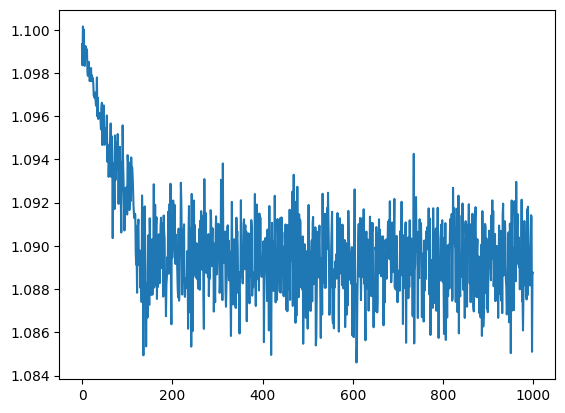

In [5]:
plt.plot(losses)

In [6]:
@pz.pytree_dataclass
class SaveActivations(pz.nn.Layer):
  saved_activations: pz.StateVariable[list[Any]]
  def __call__(self, activations: Any, **unused_side_inputs) -> Any:
    self.saved_activations.value = self.saved_activations.value + [activations]
    return activations

In [7]:
saved_activations = pz.StateVariable(value=[], label="activations")

saving_model = (
    pz.select(model)
    .at_instances_of(eqx.nn.Lambda)
    .insert_after(SaveActivations(saved_activations))
)

saving_model

RNN(
  hidden_sizes=[64, 64, 64, 64],
  layers=Sequential(
    layers=(
      Lambda(
        fn=GRUFn(
          cell=GRUCell(
            weight_ih=f32[192,1],
            weight_hh=f32[192,64],
            bias=f32[192],
            bias_n=f32[64],
            input_size=1,
            hidden_size=64,
            use_bias=True
          )
        )
      ),
      SaveActivations(
        saved_activations=StateVariable(label='activations', value=[], metadata={})
      ),
      Lambda(
        fn=GRUFn(
          cell=GRUCell(
            weight_ih=f32[192,64],
            weight_hh=f32[192,64],
            bias=f32[192],
            bias_n=f32[64],
            input_size=64,
            hidden_size=64,
            use_bias=True
          )
        )
      ),
      SaveActivations(
        saved_activations=StateVariable(label='activations', value=[], metadata={})
      ),
      Lambda(
        fn=GRUFn(
          cell=GRUCell(
            weight_ih=f32[192,64],
            weight_hh=f32[192,64],
            bias=f32[192],
            bias_n=f32[64],
            input_size=64,
            hidden_size=64,
            use_bias=True
          )
        )
      ),
      SaveActivations(
        saved_activations=StateVariable(label='activations', value=[], metadata={})
      ),
      Lambda(
        fn=GRUFn(
          cell=GRUCell(
            weight_ih=f32[192,64],
            weight_hh=f32[192,64],
            bias=f32[192],
            bias_n=f32[64],
            input_size=64,
            hidden_size=64,
            use_bias=True
          )
        )
      ),
      SaveActivations(
        saved_activations=StateVariable(label='activations', value=[], metadata={})
      ),
      Lambda(
        fn=LinearFn(
          linear=Linear(
            weight=f32[3,64],
            bias=f32[3],
            in_features=64,
            out_features=3,
            use_bias=True
          )
        )
      ),
      SaveActivations(
        saved_activations=StateVariable(label='activations', value=[], metadata={})
      )
    )
  )
)

In [8]:
gen_process_states = jnp.repeat(initial_gen_process_state[None, :], batch_size, axis=0)
batch_keys = jax.random.split(key, batch_size)
_, obs = generative_process.generate(gen_process_states, batch_keys, sequence_len)
obs = obs[:, :, None]
pz.nx.wrap(obs, "batch", "sequence", "features")

<NamedArray int32(| batch:128, sequence:64, features:1) [≥0, ≤2] zero:2_816 nonzero:5_376 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

In [11]:
logits = eqx.filter_vmap(saving_model)(obs)
logits = pz.nx.wrap(logits, "batch", "sequence", "vocab")
logits

<NamedArray float32(| batch:128, sequence:64, vocab:3) ≈0.049 ±0.036 [≥0.016, ≤0.1] nonzero:24_576 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

In [12]:
saved_activations = saved_activations.__class__(
    value=[value.val for value in saved_activations.value],  # Convert batch traced array to regular array
    label=saved_activations.label,
    metadata=saved_activations.metadata,
)

saved_activations

StateVariable(label='activations', value=[<jax.Array float32(64, 128, 64) ≈0.0088 ±0.11 [≥-0.31, ≤0.35] nonzero:524_288>, <jax.Array float32(64, 128, 64) ≈-0.0033 ±0.12 [≥-0.36, ≤0.29] nonzero:524_288>, <jax.Array float32(64, 128, 64) ≈0.0061 ±0.11 [≥-0.27, ≤0.27] nonzero:524_288>, <jax.Array float32(64, 128, 64) ≈-0.015 ±0.1 [≥-0.24, ≤0.24] nonzero:524_288>, <jax.Array float32(64, 128, 3) ≈0.049 ±0.036 [≥0.016, ≤0.1] nonzero:24_576>, <jax.Array float32(64, 128, 64) ≈0.0088 ±0.11 [≥-0.31, ≤0.35] nonzero:524_288>, <jax.Array float32(64, 128, 64) ≈-0.0033 ±0.12 [≥-0.36, ≤0.29] nonzero:524_288>, <jax.Array float32(64, 128, 64) ≈0.0061 ±0.11 [≥-0.27, ≤0.27] nonzero:524_288>, <jax.Array float32(64, 128, 64) ≈-0.015 ±0.1 [≥-0.24, ≤0.24] nonzero:524_288>, <jax.Array float32(64, 128, 3) ≈0.049 ±0.036 [≥0.016, ≤0.1] nonzero:24_576>, <jax.Array float32(64, 128, 64) ≈0.0088 ±0.11 [≥-0.31, ≤0.35] nonzero:524_288>, <jax.Array float32(64, 128, 64) ≈-0.0033 ±0.12 [≥-0.36, ≤0.29] nonzero:524_288>, <jax.Array float32(64, 128, 64) ≈0.0061 ±0.11 [≥-0.27, ≤0.27] nonzero:524_288>, <jax.Array float32(64, 128, 64) ≈-0.015 ±0.1 [≥-0.24, ≤0.24] nonzero:524_288>, <jax.Array float32(64, 128, 3) ≈0.049 ±0.036 [≥0.016, ≤0.1] nonzero:24_576>], metadata={})

In [6]:
repo_dir = Path("/workspaces/simplexity")
checkpoints_dir = repo_dir / "checkpoints"

if not checkpoints_dir.exists():
  checkpoints_dir.mkdir(parents=True)

model_path = checkpoints_dir / "model.eqx"
eqx.tree_serialise_leaves(model_path, model)


In [7]:
model = eqx.tree_deserialise_leaves(model_path, model)